In [4]:


import json
import os
import re
import time
from types import SimpleNamespace
from collections import defaultdict
from typing import Annotated, TypedDict

import torch
import pandas as pd

from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
from openai import AzureOpenAI

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer, DPRContextEncoder, DPRContextEncoderTokenizer

# ----------------- LangGraph Imports ----------------- #
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


In [ ]:

# ----------------- Define the Pipeline State ----------------- #
class MyState(TypedDict):
    messages: list                # Chat or user messages
    subgraph_file_path: str       # Path to the subgraph text file
    subgraph_text: str            # Raw content of the file
    subgraph_documents: dict      # Parsed subgraph documents {header: content}
    entity_index: dict            # Maps object strings to list of headers
    document_list: list           # List of subgraph headers (order preserved)
    header_to_doc: dict           # Maps a header to its full document text
    parsed_query: dict            # Output of query parsing
    ranked_subgraphs: list        # List of (doc_string, score)
    final_answer: str             # The final generated answer

# Global store for retrieval models and DPR objects
GLOBAL_STATE = {}


In [6]:

# ----------------- Configuration and Client Setup ----------------- #
def load_config():
    try:
        with open(r"config.json", "r", encoding="utf-8") as f:
            return json.load(f, object_hook=lambda d: SimpleNamespace(**d))
    except FileNotFoundError:
        raise FileNotFoundError("Config file not found. Please check the path.")

def initialize_azure_client(config):
    client = SecretClient(vault_url=config.key_vault_url, credential=DefaultAzureCredential())
    secret = client.get_secret(config.dev_secret_name)
    return AzureOpenAI(api_key=secret.value, api_version=config.chat.api_version, azure_endpoint=config.chat.azure_endpoint)


In [7]:

# ----------------- Node 1: Read Subgraph File ----------------- #
def read_subgraph_text_node(state: MyState):
    file_path = state["subgraph_file_path"]
    with open(file_path, "r", encoding="utf-8") as f:
        subgraph_text = f.read()
    return {"subgraph_text": subgraph_text}

# ----------------- Node 2: Prepare Subgraph Documents ----------------- #
def prepare_subgraph_documents_node(state: MyState):
    text = state["subgraph_text"].replace("\r", "").strip()
    # Split by the pattern "Subgraph for <header>:"
    parts = re.split(r"\nSubgraph for (http[s]?://[^\s:]+):?", text)
    subgraph_documents = {}
    for i in range(1, len(parts), 2):
        header = parts[i].strip()
        content = parts[i+1].strip()
        subgraph_documents[header] = content
    return {"subgraph_documents": subgraph_documents}


In [8]:

# ----------------- Node 3: Build Entity Index ----------------- #
def build_entity_index_node(state: MyState):
    subgraph_docs = state["subgraph_documents"]
    entity_index = defaultdict(list)
    for header, doc in subgraph_docs.items():
        for line in doc.split("\n"):
            parts = line.split()
            if len(parts) >= 3:
                obj = " ".join(parts[2:])
                entity_index[obj].append(header)
    return {"entity_index": dict(entity_index)}


In [9]:

# ----------------- Node 4: Prepare Retrieval Models ----------------- #
def prepare_retrieval_models_node(state: MyState):
    subgraph_docs = state["subgraph_documents"]
    document_list = list(subgraph_docs.keys())
    header_to_doc = {h: f"Subgraph for {h}\n{subgraph_docs[h]}" for h in document_list}
    corpus = [header_to_doc[h] for h in document_list]

    # TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    
    def tokenize_text(text):
        return re.findall(r'\w+', text.lower())
    tokenized_corpus = [tokenize_text(doc) for doc in corpus]

    # DPR Setup
    dpr_question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
    dpr_question_model = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
    dpr_context_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
    dpr_context_model = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

    header_embeddings = {}
    for header in document_list:
        text = header_to_doc[header]
        inputs = dpr_context_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            output = dpr_context_model(**inputs)
        header_embeddings[header] = output.pooler_output

    GLOBAL_STATE["tfidf_vectorizer"] = tfidf_vectorizer
    GLOBAL_STATE["tokenized_corpus"] = tokenized_corpus
    GLOBAL_STATE["dpr_question_tokenizer"] = dpr_question_tokenizer
    GLOBAL_STATE["dpr_question_model"] = dpr_question_model
    GLOBAL_STATE["dpr_context_tokenizer"] = dpr_context_tokenizer
    GLOBAL_STATE["dpr_context_model"] = dpr_context_model
    GLOBAL_STATE["header_embeddings"] = header_embeddings

    return {"document_list": document_list, "header_to_doc": header_to_doc}


In [ ]:

# ----------------- Node 5: Parse Query ----------------- #
def parse_query_node(state: MyState):
    query = state["messages"][-1]["content"]
    config = load_config()
    llm = initialize_azure_client(config)
    prompt = [
        {
            "role": "system",
            "content": f"""
            You are given a natural language query related to employee and organization data. Extract the following details from the query:
            - Entities mentioned in the query (e.g., Person name, Organization ID )
            - Relationships or attributes being asked for (e.g., line manager, contact info, worksFor)
            - Map these relationships or attributes to the correct schema predicates as defined below:
            - Person type: Person
            - Organization type: Organization
            - Application type: Application
            - Process Type: Process
            - Works For: worksFor
            - Email address: email
            - last Name: familyName
            - First Name: givenName
            - Organisation name : name
            - Employee status: status
            - Description of the organisation : description
            - Location: location
            - Identifier (GID): gid
            - Job Title: jobTitle
            - Functional Manager: functionalManager
            - Manager: hasManager
            - Manges/reporting to: manages
            - Contact Info: telephone
            - User Type: userType
            - Parent Organization: parentOrganization
            - Has Head: hasHead
            - Has Child Organization: hasChildOrganization
            - Organisation has Process: hasProcess
            - Title of the application: appName
            - Description of the application : appDescription
            - Application access link : accessLink 
            - Application link : appLink
            - Application image: appImage
            - Application belong to the organisation : partOfOrg
            - Application managed by: managedBy
            - people managing application : manages
            - Application Owner: hasOwner
            - Application part of Process: partOfProcess
            - Process title: title
            - Process description: description
            - Process description: description
            - Process has application: hasApplication
            - Process has owner: hasOwner
            - Process has manager: managedBy
            - Process has child process: hasChildProcess
            - Employee manages process: manages
            - Process has a parent process: prentProcess
            - Process part of an organisation: partOfOrg
            - Process Id : processId
            - Process reference Urls: referenceUrls
            - Process template urls: templateUrls
            - The goal of the query

            Provide the response in a JSON format with keys: "entities", "relationships", "goal".
            Do not include additional formatting other than JSON.
            Sample Output:
            {{
            "entities": {{
                "Dominik Schlueter": "Person",
                "Anubhuti Singh": "Person"
            }},
            "relationships": {{
                "telephone": "phone number",
                "gid": "gid",
                "email": "email"
            }},
            "goal": "To retrieve the phone number, GID, and email address of Dominik Schlueter and Anubhuti Singh."
            }}
            Query: "{query}"
            """
        }
    ]
    response = llm.chat.completions.create(model=config.chat.model, messages=prompt)
    content = response.choices[0].message.content.strip()
    parsed_data = json.loads(content)
    if isinstance(parsed_data.get("entities", {}), dict):
        entities = [{"name": k.strip(), "type": v.strip()} for k, v in parsed_data["entities"].items()]
    else:
        entities = parsed_data.get("entities", [])
    if isinstance(parsed_data.get("relationships", {}), dict):
        relationships = [{"relation": k.strip(), "value": v.strip()} for k, v in parsed_data["relationships"].items()]
    else:
        relationships = parsed_data.get("relationships", [])
    goal = parsed_data.get("goal", "")
    return {"parsed_query": {"entities": entities, "relationships": relationships, "goal": goal}}


In [ ]:

# ----------------- Functions for Ranking ----------------- #
def tfidf_rank_documents(query_terms, documents):
    doc_ids = list(documents.keys())
    docs = [f"Subgraph for {header}\n{documents[header]}" for header in doc_ids]
    tfidf_vectorizer = GLOBAL_STATE["tfidf_vectorizer"]
    tfidf_vectorizer.fit(docs)
    query_text = " ".join(query_terms)
    query_vector = tfidf_vectorizer.transform([query_text])
    doc_matrix = tfidf_vectorizer.transform(docs)
    scores = cosine_similarity(query_vector, doc_matrix).flatten()
    results = []
    for idx, score in enumerate(scores):
        header = doc_ids[idx]
        doc_text = f"Subgraph for {header}\n{documents[header]}"
        results.append((doc_text, score))
    results.sort(key=lambda x: x[1], reverse=True)
    return results

def dpr_rank_documents(query_terms, documents):
    query_text = " ".join(query_terms)
    dpr_question_tokenizer = GLOBAL_STATE["dpr_question_tokenizer"]
    dpr_question_model = GLOBAL_STATE["dpr_question_model"]
    inputs = dpr_question_tokenizer(query_text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        query_emb = dpr_question_model(**inputs).pooler_output
    results = []
    for header in documents.keys():
        doc_emb = GLOBAL_STATE["header_embeddings"][header]
        sim_score = torch.nn.functional.cosine_similarity(query_emb, doc_emb, dim=1).item()
        doc_text = f"Subgraph for {header}\n{documents[header]}"
        results.append((doc_text, sim_score))
    results.sort(key=lambda x: x[1], reverse=True)
    return results

def rrf_fusion(results1, results2, k=60):
    doc_to_rrf = {}
    for rank, (doc, _) in enumerate(results1, start=1):
        doc_to_rrf.setdefault(doc, 0)
        doc_to_rrf[doc] += 1.0 / (k + rank)
    for rank, (doc, _) in enumerate(results2, start=1):
        doc_to_rrf.setdefault(doc, 0)
        doc_to_rrf[doc] += 1.0 / (k + rank)
    fused = [(doc, score) for doc, score in doc_to_rrf.items()]
    fused.sort(key=lambda x: x[1], reverse=True)
    return fused

def rank_documents_rrf(query_terms, documents):
    tfidf_results = tfidf_rank_documents(query_terms, documents)
    dense_results = dpr_rank_documents(query_terms, documents)
    return rrf_fusion(tfidf_results, dense_results)


In [12]:

# ----------------- Node 6: Match Subgraphs ----------------- #
def match_subgraphs_node(state: MyState):
    parsed_query = state["parsed_query"]
    subgraph_documents = state["subgraph_documents"]
    entity_index = state["entity_index"]
    document_list = state["document_list"]
    header_to_doc = state["header_to_doc"]

    entities = parsed_query.get("entities", [])
    relationships = parsed_query.get("relationships", [])
    entity_names = [ent.get("name", "") for ent in entities if ent.get("name")]
    relationship_names = []
    for rel in relationships:
        if isinstance(rel, dict):
            if rel.get("relation"):
                relationship_names.append(rel["relation"])
            if rel.get("value"):
                relationship_names.append(rel["value"])
        elif isinstance(rel, str):
            relationship_names.append(rel)
    query_terms = entity_names + relationship_names

    filtered_headers = set()
    for name in entity_names:
        if name in entity_index:
            filtered_headers.update(entity_index[name])
    if filtered_headers:
        docs_by_entity = {h: subgraph_documents[h] for h in filtered_headers}
    else:
        docs_by_entity = subgraph_documents

    ranked_entity = rank_documents_rrf(query_terms, docs_by_entity)

    subjects_found = set()
    for header, doc_str in docs_by_entity.items():
        for line in doc_str.split("\n"):
            parts = line.split()
            if len(parts) >= 3:
                subj = parts[0]
                obj = " ".join(parts[2:])
                if obj in entity_names:
                    subjects_found.add(subj)
                    break
    primary_ids = list(subjects_found) if subjects_found else []

    if primary_ids:
        primary_docs = {}
        for pid in primary_ids:
            if pid in entity_index:
                for h in entity_index[pid]:
                    primary_docs[h] = subgraph_documents[h]
            else:
                primary_docs = subgraph_documents
    else:
        primary_docs = subgraph_documents

    ranked_primary = rank_documents_rrf(primary_ids, primary_docs) if primary_ids else []

    top_ranked_entity_docs = ranked_entity[:15]
    top_ranked_primary_docs = ranked_primary[:15] if ranked_primary else []

    if top_ranked_entity_docs:
        doc, score = top_ranked_entity_docs[0]
        top_ranked_entity_docs[0] = (doc, score + 10.0)
    if top_ranked_primary_docs:
        doc, score = top_ranked_primary_docs[0]
        top_ranked_primary_docs[0] = (doc, score + 10.0)

    combined = {}
    for doc, score in top_ranked_entity_docs:
        combined[doc] = score
    for doc, score in top_ranked_primary_docs:
        if doc not in combined:
            combined[doc] = score
    combined_ranked = sorted([(doc, score) for doc, score in combined.items()], key=lambda x: x[1], reverse=True)[:15]

    rel_set = set(relationship_names)
    additional_docs = []
    visited = set()
    def retrieve_additional(top_docs, rel_set, subgraph_documents, visited):
        if not top_docs:
            return []
        top_doc, _ = top_docs[0]
        extras = []
        for line in top_doc.split("\n")[1:]:
            parts = line.split()
            if len(parts) >= 3:
                subj = parts[0]
                pred = parts[1]
                obj = " ".join(parts[2:])
                for rel in rel_set:
                    if pred.endswith(rel) and obj in subgraph_documents and obj not in visited:
                        visited.add(obj)
                        extras.append((f"Subgraph for {obj}\n{subgraph_documents[obj]}", 0.0))
        return extras
    additional_docs.extend(retrieve_additional(top_ranked_entity_docs, rel_set, subgraph_documents, visited))
    additional_docs.extend(retrieve_additional(top_ranked_primary_docs, rel_set, subgraph_documents, visited))

    final_ranked = combined_ranked + additional_docs
    final_ranked = final_ranked[:15]
    return {"ranked_subgraphs": final_ranked}


In [13]:

# ----------------- Node 7: Generate Answer ----------------- #
def generate_answer_node(state: MyState):
    query = state["messages"][-1]["content"]
    top_docs = state["ranked_subgraphs"]
    context = "\n\n".join([doc for doc, score in top_docs])
    config = load_config()
    llm = initialize_azure_client(config)
    prompt = [
        {
            "role": "system",
            "content": f"""
            You are an AI assistant tasked with answering a query based on the provided context about employees and organizations.
            Please provide a detailed and well-structured answer to the user's question.

            - If applicable, organize the answer into bullet points.
            - Use headings where relevant to indicate different parts of the answer.
            - If multiple people or entities are mentioned, separate them clearly.
            - Include all relevant details in a concise yet informative way.

            Context:
            {context}

            Question: "{query}"

            Provide a well-structured and easy-to-read answer.
            """
        }
    ]
    response = llm.chat.completions.create(model=config.chat.model, messages=prompt)
    answer_text = response.choices[0].message.content.strip()
    return {"final_answer": format_answer(answer_text)}

def format_answer(answer: str):
    lines = [f"- {line.strip()}" if line.strip() and not line.strip().startswith("-") else line.strip() for line in answer.splitlines()]
    return "\n".join(lines)


In [ ]:

# ----------------- Build LangGraph Pipeline ----------------- #
graph_builder = StateGraph(MyState)
memory = MemorySaver()

graph_builder.add_node("read_subgraph", read_subgraph_text_node)
graph_builder.add_node("prepare_subgraph_documents", prepare_subgraph_documents_node)
graph_builder.add_node("build_entity_index", build_entity_index_node)
graph_builder.add_node("prepare_retrieval_models", prepare_retrieval_models_node)
graph_builder.add_node("parse_query", parse_query_node)
graph_builder.add_node("match_subgraphs", match_subgraphs_node)
graph_builder.add_node("generate_answer", generate_answer_node)

graph_builder.add_edge(START, "read_subgraph")
graph_builder.add_edge("read_subgraph", "prepare_subgraph_documents")
graph_builder.add_edge("prepare_subgraph_documents", "build_entity_index")
graph_builder.add_edge("build_entity_index", "prepare_retrieval_models")
graph_builder.add_edge("prepare_retrieval_models", "parse_query")
graph_builder.add_edge("parse_query", "match_subgraphs")
graph_builder.add_edge("match_subgraphs", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile(checkpointer=memory)

if __name__ == "__main__":
    file_path = r"kgCreation/FinSubGraphLatestPro.txt"
    query = "What is the email address of anubhuti singh?"
    initial_state = {
        "messages": [{"role": "user", "content": query}],
        "subgraph_file_path": file_path,
        "subgraph_text": "",
        "subgraph_documents": {},
        "entity_index": {},
        "document_list": [],
        "header_to_doc": {},
        "parsed_query": {},
        "ranked_subgraphs": [],
        "final_answer": ""
    }
    events = graph.stream(initial_state, {"configurable": {"thread_id": "1"}}, stream_mode="values")
    final_state = None
    for event in events:
        final_state = event
    print("Answer:")
    print(final_state.get("final_answer", "No answer generated."))


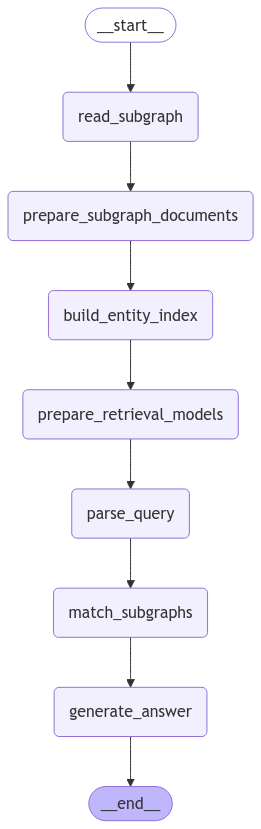

In [17]:

try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass
